The first cell takes care of any imports/installs we will be needing. This ensures that anyone using the dataset & notebook has all of the required libraries

For the purposes of the project, taxes are excluded

In [2]:
# If you’re running in a fresh environment, install required libraries and adjust output presentation in vscode
!pip install scipy statsmodels mlxtend seaborn

# Data handling
import pandas as pd
import numpy as np
import random
import uuid

# Date/time
from datetime import datetime, timedelta

# Statistical tests & smoothing
import scipy.stats as stats
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans

# Association rules
from mlxtend.frequent_patterns import apriori, association_rules

# Visualization

!pip install ipywidgets
import ipywidgets as widgets
from IPython.display import display, Markdown, HTML
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context("notebook")

# show all columns, rows, and unlimited column width
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)         
pd.set_option('display.max_colwidth', None)     # no truncation of text
pd.set_option('display.width', 1000)            


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=1224) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=1224) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


Next, we will import our dataset as a pandas dataframe, so that we can start to analyz the data

In [3]:
# Load the data into a DataFrame
df = pd.read_csv(
    "synthetic_restaurant_sales.csv",
    parse_dates=["transaction_time", "date"]
)

df.head(5)

,restaurant_id,cuisine,transaction_id,transaction_time,date,day_of_week,time_of_day,party_size,item_name,quantity,item_price,transaction_amount,payment_method,order_type,is_weekend,weather,temperature_f,tip_amount
0,0,Italian,AJI0Y6DPB,2024-01-28 08:28:15,2024-01-28,Sunday,Breakfast,1,Frittata,1,10.0,10.0,Swipe/Insert Card,Takeout,True,Cloudy,26.4,0.79
1,4,Mediterranean,PQK51FPKH,2024-02-13 03:43:16,2024-02-13,Tuesday,Lunch,4,Dolma,2,8.0,16.0,Swipe/Insert Card,Dine-in,False,Rain,36.6,29.32
2,4,Mediterranean,PQK51FPKH,2024-02-13 03:43:16,2024-02-13,Tuesday,Lunch,4,Greek Salad,2,9.0,18.0,Swipe/Insert Card,Dine-in,False,Rain,36.6,29.32
3,4,Mediterranean,PQK51FPKH,2024-02-13 03:43:16,2024-02-13,Tuesday,Lunch,4,Hummus Plate,2,8.0,16.0,Swipe/Insert Card,Dine-in,False,Rain,36.6,29.32
4,4,Mediterranean,PQK51FPKH,2024-02-13 03:43:16,2024-02-13,Tuesday,Lunch,4,Turkish Coffee,1,3.5,3.5,Swipe/Insert Card,Dine-in,False,Rain,36.6,29.32


The data set contatins data from many resturants in two cities (NYC and LA). This cell will show the menus for each of these resturants.

In [4]:
# Prepare the menu_items DataFrame 
menu_items = (
    df[~df['item_name'].isin(['Tip', 'Auto Grat'])]
      [['restaurant_id','cuisine','item_name','item_price','time_of_day']]
      .drop_duplicates()
      .sort_values(['restaurant_id','time_of_day','item_name'])
)
menu_items['Location'] = np.where(
    menu_items['restaurant_id'] % 2 == 0, 'NYC', 'LA'
)
menu_items.rename(columns={
    'item_name': 'Menu Item',
    'item_price':'Price',
    'time_of_day':'Meal'
}, inplace=True)

restaurant_ids = sorted(menu_items['restaurant_id'].unique())

# Create one Tab per restaurant
tabs = widgets.Tab()

individualRes = []
for rid in restaurant_ids:
    sub = menu_items[menu_items['restaurant_id'] == rid]
    loc = sub['Location'].iat[0]
    cuisine = sub['cuisine'].iat[0]
    
    # Build one VBox per meal
    meal_boxes = []
    for meal in ['Breakfast','Lunch','Dinner']:
        df_meal = sub[sub['Meal']==meal][['Menu Item','Price']].reset_index(drop=True)
        if df_meal.empty:
            # show an empty placeholder
            box = widgets.VBox([widgets.HTML(f"<h3>{meal}</h3>"),
                                widgets.HTML("<i>No items</i>")])
        else:
            out = widgets.Output()
            with out:
                display(df_meal)
            box = widgets.VBox([widgets.HTML(f"<h3>{meal}</h3>"), out])
        meal_boxes.append(box)
    
    # Put the three meal boxes in one horizontal box
    tab_content = widgets.VBox([
        widgets.HTML(f"<h2>Restaurant {rid} — {loc}, {cuisine}</h2>"),
        widgets.HBox(meal_boxes, layout=widgets.Layout(justify_content='space-between'))
    ])
    individualRes.append(tab_content)

tabs.children = individualRes
for i, rid in enumerate(restaurant_ids):
    tabs.set_title(i, f"R{rid}")

display(tabs)

Each row does not represent a transaction, rather a single item. To view transaction as a whole, we must combine the data in each row by the transaction id. This cell also used widgets to make it easier to view and understand the data

In [5]:


# 1. Total spent per transaction
total_spent = df.groupby('transaction_id')['transaction_amount'] \
                .sum() \
                .rename('total_spent')

# 2. First values for other fields
first_vals = df.groupby('transaction_id').agg({
    'party_size'    :'first',
    'cuisine'       :'first',
    'restaurant_id' :'first',
    'is_weekend'    :'first',
    'weather'       :'first'
})

# 3. Tip per transaction
tips = (
    df.groupby('transaction_id')['tip_amount']
      .first()
      .rename('tip_amount')
      .reindex(first_vals.index, fill_value=0)
)

# 4. Dishes string per transaction (no warning)
dishes = (
    df
    .groupby(['transaction_id','item_name'])['quantity']
    .sum()
    .reset_index()
    .groupby('transaction_id', group_keys=False)
    .apply(lambda g: ", ".join(
        f"{row.item_name}({int(row.quantity)})"
        for row in g.itertuples()
    ))
    .rename('dishes')
)

# 5. Derive location
first_vals['location'] = np.where(
    first_vals['restaurant_id'] % 2 == 0, 'NYC', 'LA'
)

# 6. Build summary_df
summary_df = (
    pd.concat([first_vals, total_spent, tips, dishes], axis=1)
      .reset_index()[[
          'transaction_id','party_size','total_spent','tip_amount',
          'dishes','cuisine','location','is_weekend','weather',
          'restaurant_id'   # keep for filtering tabs
      ]]
)

# 7. Tabbed display per restaurant
restaurant_ids = sorted(summary_df['restaurant_id'].unique())
tabs = widgets.Tab(children=[widgets.Output() for _ in restaurant_ids])

for idx, rid in enumerate(restaurant_ids):
    with tabs.children[idx]:
        sub = summary_df[summary_df['restaurant_id']==rid] \
                  .drop(columns='restaurant_id')
        html = sub.to_html(index=False)
        display(HTML(
            "<div style='max-height:400px; overflow:auto; "
            "border:1px solid #ddd; padding:8px;'>" +
            html +
            "</div>"
        ))
    tabs.set_title(idx, f"Restaurant {rid}")

display(tabs)


/var/folders/f3/kshn2pqs019_tgj2x6p4trkm0000gn/T/ipykernel_1224/1808341887.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: ", ".join(


This cell zeroes in on payment methods—transforming raw transactions into a concise summary and then displaying five side-by-side visualizations that reveal how payment choice correlates with spend distribution, time-of-day usage, average ticket size, cuisine preferences, and tipping behavior. By comparing these metrics, you can quickly understand not just which methods prevail, but how they tie into order size, customer habits, and generosity across different dining contexts.

/var/folders/f3/kshn2pqs019_tgj2x6p4trkm0000gn/T/ipykernel_1224/888770852.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_to_plot, labels=pay_stats.index, showfliers=False)


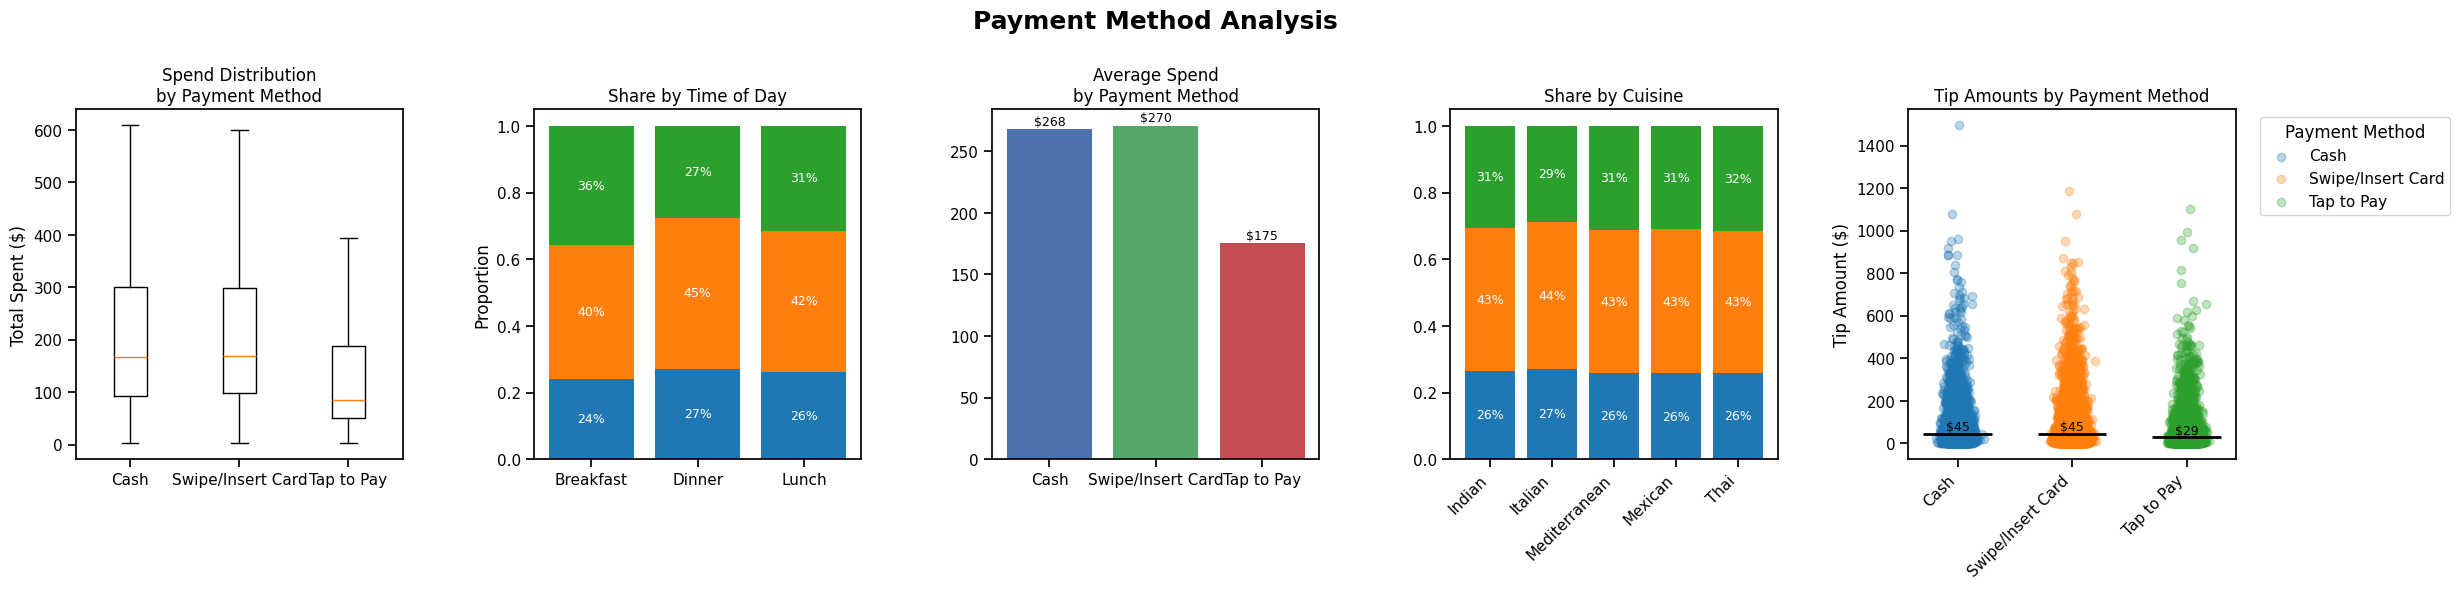

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Build summary_df including tip_amount
summary_df = (
    df.groupby('transaction_id')
      .agg(
          total_spent     = ('transaction_amount','sum'),
          tip_amount      = ('tip_amount','first'),
          payment_method  = ('payment_method','first'),
          time_of_day     = ('time_of_day','first'),
          cuisine         = ('cuisine','first')
      )
      .reset_index()
)

# 2. Prepare pivots/stats
# a) Share by time_of_day
time_pivot = summary_df.groupby(['time_of_day','payment_method']).size().unstack(fill_value=0)
time_prop  = time_pivot.div(time_pivot.sum(axis=1), axis=0)
# b) Avg spend by payment_method
pay_stats = summary_df.groupby('payment_method').agg(
    count     = ('transaction_id','nunique'),
    avg_spent = ('total_spent','mean')
).reindex(['Cash','Swipe/Insert Card','Tap to Pay'])
# c) Share by cuisine
cuisine_pivot = summary_df.groupby(['cuisine','payment_method']).size().unstack(fill_value=0)
cuisine_prop  = cuisine_pivot.div(cuisine_pivot.sum(axis=1), axis=0)

# 3. Plot 5 charts in a 1×5 row
fig, axes = plt.subplots(1, 5, figsize=(24, 5))
fig.suptitle('Payment Method Analysis', fontsize=18, weight='bold', y=1.05, x=0.5, ha='center')
plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15, wspace=0.4)

# (0) Boxplot of Spend Distribution
ax = axes[0]
data_to_plot = [summary_df.loc[summary_df.payment_method==m, 'total_spent']
                for m in pay_stats.index]
ax.boxplot(data_to_plot, labels=pay_stats.index, showfliers=False)
ax.set_title('Spend Distribution\nby Payment Method')
ax.set_ylabel('Total Spent ($)')

# (1) Share by Time of Day
ax = axes[1]
bottom = np.zeros(len(time_prop))
x = np.arange(len(time_prop))
for method in time_prop.columns:
    vals = time_prop[method].values
    bars = ax.bar(x, vals, bottom=bottom, label=method)
    for bar, v in zip(bars, vals):
        if v >= 0.03:
            ax.text(bar.get_x()+bar.get_width()/2, bar.get_y()+v/2,
                    f'{v:.0%}', ha='center', va='center', color='white', fontsize=9)
    bottom += vals
ax.set_xticks(x)
ax.set_xticklabels(time_prop.index, rotation=0)
ax.set_title('Share by Time of Day')
ax.set_ylabel('Proportion')

# (2) Avg Transaction Amount by Payment Method
ax = axes[2]
bars = ax.bar(pay_stats.index, pay_stats['avg_spent'], color=['#4C72B0','#55A868','#C44E52'])
ax.set_title('Average Spend\nby Payment Method')
for bar, v in zip(bars, pay_stats['avg_spent']):
    ax.text(bar.get_x() + bar.get_width()/2, v + 1, f'${v:.0f}',
            ha='center', va='bottom', fontsize=9)

# (3) Share by Cuisine
ax = axes[3]
bottom = np.zeros(len(cuisine_prop))
x = np.arange(len(cuisine_prop))
for method in cuisine_prop.columns:
    vals = cuisine_prop[method].values
    bars = ax.bar(x, vals, bottom=bottom, label=method)
    for bar, v in zip(bars, vals):
        if v >= 0.03:
            ax.text(bar.get_x()+bar.get_width()/2, bar.get_y()+v/2,
                    f'{v:.0%}', ha='center', va='center', color='white', fontsize=9)
    bottom += vals
ax.set_xticks(x)
ax.set_xticklabels(cuisine_prop.index, rotation=45, ha='right')
ax.set_title('Share by Cuisine')

# (4) Scatter of Tip Amounts by Payment Method
ax = axes[4]
methods = pay_stats.index.tolist()
for i, method in enumerate(methods):
    tips = summary_df.loc[summary_df.payment_method==method, 'tip_amount']
    jitter = np.random.normal(loc=i, scale=0.05, size=len(tips))
    ax.scatter(jitter, tips, alpha=0.3, label=method)
# annotate mean tip
means = summary_df.groupby('payment_method')['tip_amount'].mean().reindex(methods)
for i, m in enumerate(methods):
    ax.hlines(means[m], i-0.3, i+0.3, colors='black', linewidth=2)
    ax.text(i, means[m] + 1, f'${means[m]:.0f}', ha='center', va='bottom', fontsize=9)
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, rotation=45, ha='right')
ax.set_title('Tip Amounts by Payment Method')
ax.set_ylabel('Tip Amount ($)')

# Legend on last subplot
axes[4].legend(title='Payment Method', bbox_to_anchor=(1.05,1), loc='upper left')

plt.show()


This cell dives into how the size of an order affects tipping behavior—examining both absolute tip amounts and tip as a percentage of the bill. We’ll visualize each transaction as a scatter of total spend vs. tip, then bin orders into deciles to compare median tip‐percentages across spend levels, and finally fit a smooth trend line to reveal any diminishing‐returns effect.

/var/folders/f3/kshn2pqs019_tgj2x6p4trkm0000gn/T/ipykernel_1224/1317740920.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=order_types, showfliers=False)


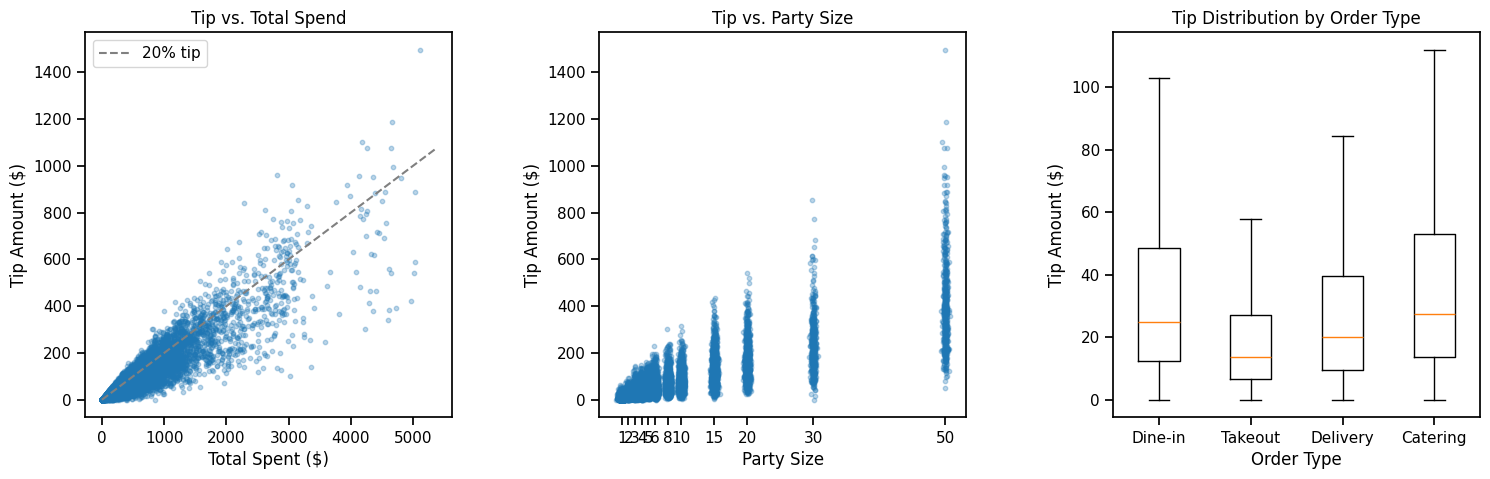

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Build transaction_summary with total_spent, tip_amount, party_size, order_type
tx = (
    df.groupby('transaction_id')
      .agg(
          total_spent = ('transaction_amount','sum'),
          tip_amount  = ('tip_amount','first'),
          party_size  = ('party_size','first'),
          order_type  = ('order_type','first')
      )
      .reset_index()
)

# 2. Plot three charts side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.subplots_adjust(wspace=0.4)

# (0) Scatter: Total Spend vs Tip Amount
ax = axes[0]
ax.scatter(tx['total_spent'], tx['tip_amount'], alpha=0.3, s=10)
ax.set_xlabel('Total Spent ($)')
ax.set_ylabel('Tip Amount ($)')
ax.set_title('Tip vs. Total Spend')
lims = [0, tx['total_spent'].max()*1.05]
ax.plot(lims, [l*0.2 for l in lims], '--', color='gray', label='20% tip')
ax.legend()

# (1) Scatter: Party Size vs Tip Amount (with jitter)
ax = axes[1]
jitter = np.random.normal(scale=0.2, size=len(tx))
ax.scatter(tx['party_size'] + jitter, tx['tip_amount'], alpha=0.3, s=10)
ax.set_xlabel('Party Size')
ax.set_ylabel('Tip Amount ($)')
ax.set_title('Tip vs. Party Size')
ax.set_xticks(sorted(tx['party_size'].unique()))

# (2) Boxplot: Tip Amount by Order Type
ax = axes[2]
order_types = ['Dine-in','Takeout','Delivery','Catering']
data = [tx.loc[tx.order_type==ot, 'tip_amount'] for ot in order_types]
bp = ax.boxplot(data, labels=order_types, showfliers=False)
ax.set_xlabel('Order Type')
ax.set_ylabel('Tip Amount ($)')
ax.set_title('Tip Distribution by Order Type')

plt.show()


This cell examines how different weather conditions correlate with sales performance and order patterns. We’ll summarize transactions by weather and then visualize:

Transaction counts per weather

Total revenue per weather

Average spend per transaction by weather

Order-type mix (Dine-in/Takeout/Delivery/Catering) by weather

Spend distribution (boxplots) across weather types

/var/folders/f3/kshn2pqs019_tgj2x6p4trkm0000gn/T/ipykernel_1224/2900132298.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(data, labels=weather_order, showfliers=False)


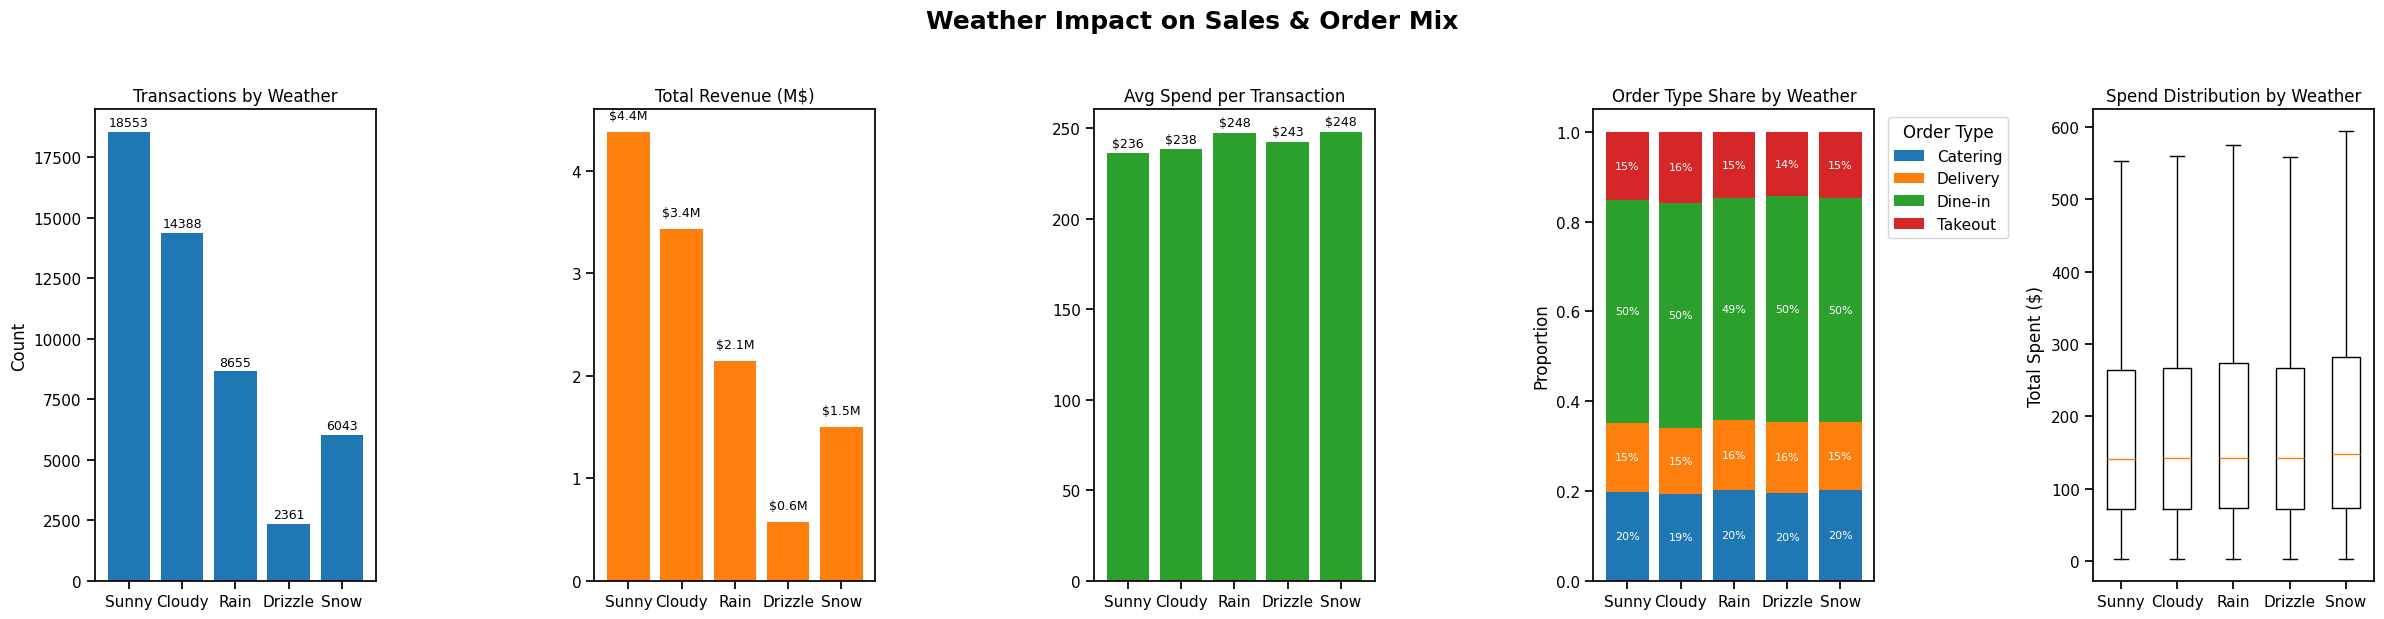

In [8]:

# 1. Build transaction summary with weather and order_type
tx_weather = (
    df.groupby('transaction_id')
      .agg(
          total_spent = ('transaction_amount','sum'),
          weather     = ('weather','first'),
          order_type  = ('order_type','first')
      )
      .reset_index()
)

# 2. Compute metrics by weather
weather_order = ['Sunny','Cloudy','Rain','Drizzle','Snow']
counts    = tx_weather['weather'].value_counts().reindex(weather_order)
revenue   = tx_weather.groupby('weather')['total_spent'].sum().reindex(weather_order)
avg_spend = tx_weather.groupby('weather')['total_spent'].mean().reindex(weather_order)
order_pivot = (
    tx_weather
      .groupby(['weather','order_type'])
      .size()
      .unstack(fill_value=0)
      .reindex(index=weather_order)
)
order_prop = order_pivot.div(order_pivot.sum(axis=1), axis=0)

# 3. Plot 5 charts side by side
fig, axes = plt.subplots(1, 5, figsize=(24, 6))
fig.suptitle('Weather Impact on Sales & Order Mix', fontsize=18, weight='bold', y=1.03)
plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.2, wspace=0.4)

# (0) Transaction counts by weather
ax = axes[0]
bars = ax.bar(counts.index, counts.values, color='C0')
ax.set_title('Transactions by Weather')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=0)
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
            f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=9)

# (1) Total revenue by weather
ax = axes[1]
bars = ax.bar(revenue.index, revenue.values/1e6, color='C1')
ax.set_title('Total Revenue (M$)')
ax.tick_params(axis='x', rotation=0)
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'${bar.get_height():.1f}M', ha='center', va='bottom', fontsize=9)

# (2) Average spend by weather
ax = axes[2]
bars = ax.bar(avg_spend.index, avg_spend.values, color='C2')
ax.set_title('Avg Spend per Transaction')
ax.tick_params(axis='x', rotation=0)
for bar, val in zip(bars, avg_spend.values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 2,
            f'${val:.0f}', ha='center', va='bottom', fontsize=9)

# (3) Order-type mix by weather (stacked)
ax = axes[3]
bottom = np.zeros(len(order_prop))
for ot in order_prop.columns:
    vals = order_prop[ot].values
    bars = ax.bar(order_prop.index, vals, bottom=bottom, label=ot)
    for bar, v in zip(bars, vals):
        if v >= 0.05:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + v/2,
                    f'{v:.0%}', ha='center', va='center', color='white', fontsize=8)
    bottom += vals
ax.set_title('Order Type Share by Weather')
ax.tick_params(axis='x', rotation=0)
ax.set_ylabel('Proportion')
ax.legend(title='Order Type', bbox_to_anchor=(1.02, 1), loc='upper left')

# (4) Spend distribution by weather (boxplots)
ax = axes[4]
data = [tx_weather.loc[tx_weather.weather==w, 'total_spent'] for w in weather_order]
bplot = ax.boxplot(data, labels=weather_order, showfliers=False)
ax.set_title('Spend Distribution by Weather')
ax.set_ylabel('Total Spent ($)')
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


This cell explores how transaction volume and spend vary across days of the week and times of day—helping identify peaks, lulls, and opportunities for targeted promotions or staffing adjustments. We’ll produce four side-by-side visuals:

A heatmap of transaction counts (day × time)

A heatmap of average spend (day × time)

A bar chart of total transactions by day

A bar chart of average spend by time of day


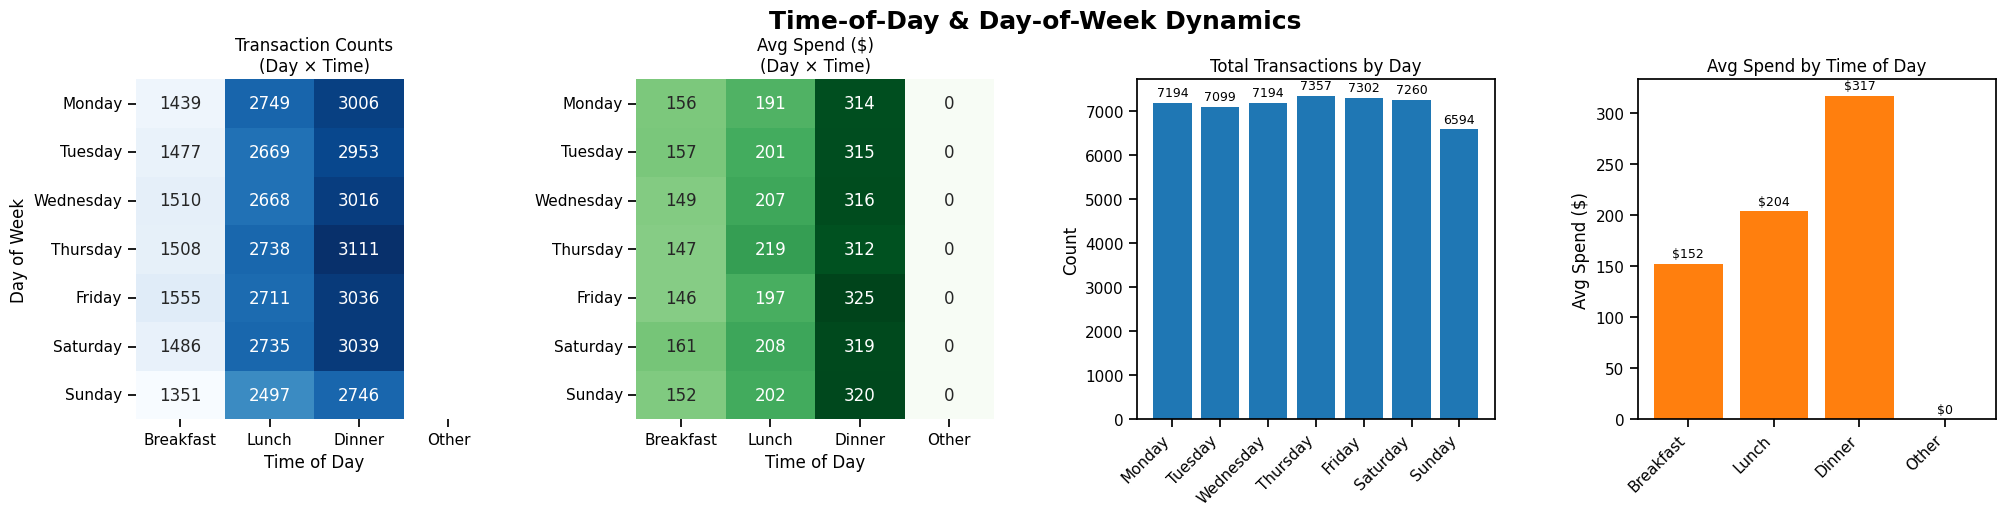

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # for heatmaps

# 1. Build transaction summary
tx_td = (
    df.groupby('transaction_id')
      .agg(
          total_spent  = ('transaction_amount','sum'),
          day_of_week  = ('day_of_week','first'),
          time_of_day  = ('time_of_day','first')
      )
      .reset_index()
)

# 2. Define ordering
days  = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
times = ['Breakfast','Lunch','Dinner','Other']

# 3. Pivot tables (fill missing with 0)
count_pivot = (
    tx_td.pivot_table(
        index='day_of_week',
        columns='time_of_day',
        values='transaction_id',
        aggfunc='nunique',
        fill_value=0
    )
    .reindex(index=days, columns=times)
)
avg_pivot = (
    tx_td.pivot_table(
        index='day_of_week',
        columns='time_of_day',
        values='total_spent',
        aggfunc='mean'
    )
    .reindex(index=days, columns=times)
    .fillna(0)
)

daily_counts   = count_pivot.sum(axis=1)
time_avg_spend = tx_td.groupby('time_of_day')['total_spent'].mean().reindex(times).fillna(0)

# 4. Plot
fig, axes = plt.subplots(1, 4, figsize=(24, 5))
fig.suptitle('Time-of-Day & Day-of-Week Dynamics', fontsize=18, weight='bold', y=1.02)
plt.subplots_adjust(wspace=0.4, bottom=0.2)

# (0) Heatmap: Transaction Counts
ax = axes[0]
sns.heatmap(
    count_pivot, annot=True, fmt='.0f', cmap='Blues', cbar=False, ax=ax
)
ax.set_title('Transaction Counts\n(Day × Time)')
ax.set_xlabel('Time of Day')
ax.set_ylabel('Day of Week')
ax.set_xticklabels(times, rotation=0)

# (1) Heatmap: Average Spend
ax = axes[1]
sns.heatmap(
    avg_pivot, annot=True, fmt='.0f', cmap='Greens', cbar=False, ax=ax
)
ax.set_title('Avg Spend ($)\n(Day × Time)')
ax.set_xlabel('Time of Day')
ax.set_ylabel('')
ax.set_xticklabels(times, rotation=0)

# (2) Bar: Total Transactions by Day
ax = axes[2]
bars = ax.bar(np.arange(len(daily_counts)), daily_counts.values, color='C0')
ax.set_title('Total Transactions by Day')
ax.set_ylabel('Count')
ax.set_xticks(np.arange(len(daily_counts)))
ax.set_xticklabels(daily_counts.index, rotation=45, ha='right')
for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        h + daily_counts.max()*0.01,
        f'{int(h)}',
        ha='center', va='bottom', fontsize=9
    )

# (3) Bar: Avg Spend by Time of Day
ax = axes[3]
bars = ax.bar(np.arange(len(time_avg_spend)), time_avg_spend.values, color='C1')
ax.set_title('Avg Spend by Time of Day')
ax.set_ylabel('Avg Spend ($)')
ax.set_xticks(np.arange(len(time_avg_spend)))
ax.set_xticklabels(time_avg_spend.index, rotation=45, ha='right')
for bar, val in zip(bars, time_avg_spend.values):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        val + time_avg_spend.max()*0.01,
        f'${val:.0f}',
        ha='center', va='bottom', fontsize=9
    )

plt.show()


This cell identifies each restaurant’s top‐selling dishes and then examines when those favorites move—showing peak meal periods and weekday performance. We’ll display:

A row of bar charts (one per restaurant) of the top 5 items by units sold

A heatmap of total item‐sales by meal period for each restaurant

A line chart of weekday sales for each restaurant’s #1 item

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

# Precompute per-restaurant summaries
restaurants = sorted(df['restaurant_id'].unique())
top_items = {
    rid: df[df.restaurant_id == rid]['item_name']
            .value_counts()
            .nlargest(5)
            .index
            .tolist()
    for rid in restaurants
}
meal_summary = (
    df.groupby(['restaurant_id','time_of_day'])['quantity']
      .sum()
      .unstack(fill_value=0)
      .reindex(index=restaurants,
               columns=['Breakfast','Lunch','Dinner','Other'])
)
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_sales = {
    rid: (
        df[(df.restaurant_id == rid) & (df.item_name == top_items[rid][0])]
        .groupby('day_of_week')['quantity']
        .sum()
        .reindex(weekday_order, fill_value=0)
    )
    for rid in restaurants
}

# Build one Output widget per restaurant
children = []
for idx, rid in enumerate(restaurants):
    out = widgets.Output()
    with out:
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        plt.subplots_adjust(wspace=0.4)
        
        # Top 5 items bar chart
        ax = axes[0]
        items = top_items[rid]
        counts = df[df.restaurant_id == rid]['item_name'].value_counts().reindex(items)
        bars = ax.barh(items[::-1], counts[::-1], color=f'C{idx}')
        ax.set_title(f'Rest {rid} – Top 5 Items')
        ax.set_xlabel('Units Sold')
        ax.invert_yaxis()
        for bar in bars:
            w = bar.get_width()
            ax.text(w + w*0.02, bar.get_y() + bar.get_height()/2,
                    f'{int(w)}', va='center')
        
        # Meal-period heatmap
        ax = axes[1]
        row = meal_summary.loc[[rid]]
        sns.heatmap(
            row, annot=True, fmt='.0f', cmap='Oranges',
            cbar=False, linewidths=0.5, linecolor='gray', ax=ax
        )
        ax.set_title(f'Rest {rid} – Sales by Meal')
        ax.set_xlabel('Meal Period')
        ax.set_ylabel('')
        
        # Weekday line chart for top item
        ax = axes[2]
        ws = weekday_sales[rid]
        ax.plot(ws.index, ws.values, marker='o', color=f'C{idx}')
        ax.set_title(f'Rest {rid} – “{top_items[rid][0]}” by Weekday')
        ax.set_xlabel('Day of Week')
        ax.set_ylabel('Units Sold')
        ax.tick_params(axis='x', rotation=45)
        
        plt.show()
    children.append(out)

# Now create the Tab widget and assign children
tabs = widgets.Tab(children=children)
for idx, rid in enumerate(restaurants):
    tabs.set_title(idx, f"Restaurant {rid}")

display(tabs)


By analyzing how sales of key ingredients and menu items fluctuate with weather, we can dynamically adjust stock orders—e.g. if cold drinks sell 20% less on rainy days, we only order 80% of our usual ingredient supply for cold drinks for those forecasts. Below, we estimate average daily unit sales for a handful of weather-sensitive items, compute relative demand factors, and project inventory multipliers by weather condition.

In [11]:

# 1. Prepare week periods and average weekly temperature
df['date_only'] = pd.to_datetime(df['transaction_time']).dt.date
df['week'] = pd.to_datetime(df['date_only']).dt.to_period('W').apply(lambda r: r.start_time.date())

weekly_temp = (
    df.groupby('week')['temperature_f']
      .mean()
      .rename('avg_temp')
)

# 2. Label weeks as hot (> median) or cold (<= median)
median_temp = weekly_temp.median()
week_label = weekly_temp.to_frame().assign(
    season=lambda d: np.where(d['avg_temp'] > median_temp, 'Hot','Cold')
)

# 3. Merge back to item‐level data
df2 = df.merge(week_label, on='week')

# 4. Top 10 items in hot vs. cold weeks
top_n = 10
hot_sales = (
    df2[df2['season']=='Hot']
      .groupby('item_name')['quantity']
      .sum()
      .nlargest(top_n)
      .rename('hot_units')
)
cold_sales = (
    df2[df2['season']=='Cold']
      .groupby('item_name')['quantity']
      .sum()
      .nlargest(top_n)
      .rename('cold_units')
)

print("Top 10 Items in Hot Weeks (Total Sales):\n", hot_sales)
print("\nTop 10 Items in Cold Weeks (Total Sales):\n", cold_sales)

# 5. Forecast next‐week sales for those top items
#    by computing each item’s avg weekly sales over historical weeks of that type
hot_weeks = week_label[week_label['season']=='Hot'].index
cold_weeks = week_label[week_label['season']=='Cold'].index

hot_forecast = (
    df2[df2['week'].isin(hot_weeks)]
      .groupby(['week','item_name'])['quantity']
      .sum()
      .groupby('item_name')
      .mean()
      .loc[hot_sales.index]
      .round()
      .astype(int)
      .rename('forecast_hot_week')
)

cold_forecast = (
    df2[df2['week'].isin(cold_weeks)]
      .groupby(['week','item_name'])['quantity']
      .sum()
      .groupby('item_name')
      .mean()
      .loc[cold_sales.index]
      .round()
      .astype(int)
      .rename('forecast_cold_week')
)

forecast_df = pd.concat([hot_forecast, cold_forecast], axis=1).fillna(0).astype(int)
print("\nForecasted Units for Next Hot Week & Next Cold Week:\n", forecast_df)


Top 10 Items in Hot Weeks (Total Sales):
 item_name
Baklava                10467
Sticky Rice & Mango     6602
Turkish Coffee          5883
Papaya Salad            5824
Espresso                5652
Red Wine (glass)        4593
Panang Curry            4553
Tostada                 4508
Thai Tea Float          4498
Seafood Platter         4490
Name: hot_units, dtype: int64

Top 10 Items in Cold Weeks (Total Sales):
 item_name
Baklava                12466
Sticky Rice & Mango     7738
Turkish Coffee          7362
Papaya Salad            7106
Espresso                6845
Arancini                5494
Antipasto Platter       5431
Tiramisu                5404
Bistecca Fiorentina     5390
Osso Buco               5379
Name: cold_units, dtype: int64

Forecasted Units for Next Hot Week & Next Cold Week:
                      forecast_hot_week  forecast_cold_week
item_name                                                 
Baklava                           1744                1781
Sticky Rice & Mango  

This cell creates a mini‐dashboard where you can pick a restaurant (tab) and then toggle between “Hot Week” vs. “Cold Week” forecasts. Each tab shows a scrollable list of all menu items for that restaurant with their predicted weekly sales under hot or cold conditions.

In [12]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display, HTML

# 0. Precompute: weekly labels & forecasts per restaurant + item
df['date_only'] = pd.to_datetime(df['transaction_time']).dt.date
df['week']      = pd.to_datetime(df['date_only']).dt.to_period('W').apply(lambda r: r.start_time.date())

# weekly average temp & hot/cold flag
weekly_temp = df.groupby('week')['temperature_f'].mean()
median_temp = weekly_temp.median()
week_season = (weekly_temp > median_temp).map({True:'Hot', False:'Cold'})

# merge back
df2 = df.merge(week_season.rename('season'), on='week')

# function to compute forecast for one restaurant & season
def compute_forecast_for_restaurant(rid):
    sub = df2[df2['restaurant_id']==rid]
    # group per week/item
    weekly_item = (sub.groupby(['week','item_name'])['quantity']
                     .sum()
                     .reset_index())
    # pivot: item × week with quantities
    pivot = weekly_item.pivot(index='item_name', columns='week', values='quantity').fillna(0)
    # determine which weeks are hot/cold
    hot_weeks  = week_season[week_season=='Hot'].index
    cold_weeks = week_season[week_season=='Cold'].index
    
    # average across those week columns
    hot_avg  = pivot[hot_weeks].mean(axis=1).round().astype(int).rename('Hot Week Forecast')
    cold_avg = pivot[cold_weeks].mean(axis=1).round().astype(int).rename('Cold Week Forecast')
    
    return pd.concat([hot_avg, cold_avg], axis=1)

# build one DataFrame per restaurant
restaurant_ids = sorted(df['restaurant_id'].unique())
forecasts = {rid: compute_forecast_for_restaurant(rid) for rid in restaurant_ids}

# 1. Build tabs
tabs = widgets.Tab()
children = []

for rid in restaurant_ids:
    # toggle between Hot/Cold
    toggle = widgets.ToggleButtons(
        options=['Hot','Cold'], 
        description='Week Type:',
        value='Hot'
    )
    out = widgets.Output(layout={'border': '1px solid lightgray',
                                 'max_height': '300px',
                                 'overflow': 'auto',
                                 'padding': '10px'})
    
    def on_toggle(change, rid=rid, out=out):
        out.clear_output()
        dfc = forecasts[rid]
        sel = change['new']
        display_df = dfc[[f'{sel} Week Forecast']].reset_index().rename(
            columns={
                'item_name': 'Menu Item',
                f'{sel} Week Forecast': 'Units Forecast'
            }
        )
        with out:
            display(HTML(display_df.to_html(index=False)))
    
    toggle.observe(on_toggle, names='value')
    
    # initialize
    on_toggle({'new':'Hot'}, rid, out)
    
    # assemble
    box = widgets.VBox([toggle, out])
    children.append(box)

tabs.children = children
for idx, rid in enumerate(restaurant_ids):
    tabs.set_title(idx, f"Restaurant {rid}")

display(widgets.HTML("<h3>Weekly Sales Forecast by Restaurant & Week‐Type</h3>"))
display(tabs)


HTML(value='<h3>Weekly Sales Forecast by Restaurant & Week‐Type</h3>')